# Goal:
Predict the apple stock price in next day by using linear regression

Given prices for the last N days, we train a model, and predict for day N+1



In [129]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
%matplotlib inline


In [130]:
# Load the file
apple_data = pd.read_csv('../ML-Project/apple.csv')
apple_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj_Close,Volume,Year,Quarter
0,0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900,2017,1
1,1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100,2017,1
2,2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600,2017,1
3,3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900,2017,1
4,4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900,2017,1


In [131]:
# Drop the columns
apple = apple_data.drop(columns=['Unnamed: 0', 'Year', 'Quarter'])
apple.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900
1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100
2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600
3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900
4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900


In [132]:
apple['Date'] = pd.to_datetime(apple.Date,format='%Y-%m-%d')


In [133]:

apple['Month'] = apple['Date'].dt.month
apple.sort_values(by='Date', inplace=True, ascending=True)
apple.head()


,Date,Open,High,Low,Close,Adj_Close,Volume,Month
0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900,1
1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100,1
2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600,1
3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900,1
4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900,1


There are multiple variables in the dataset – date, open, high, low, close, Adj_close & volume.

The columns open and close represent the starting and final price at which the stock is traded on a particular day. High and low represent the maximum, minimum, and last price of the share for the day. Volume is the number of shares bought or sold in the day.
Adjusted closing price amends a stock's closing price to accurately reflect that stock's value after accounting for any corporate actions.
we will consider the adjusted closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

Text(0, 0.5, 'Price USD')

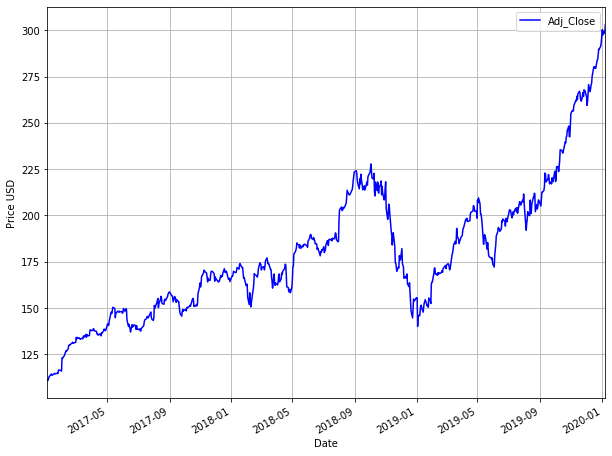

In [134]:
# Plot the data 
rcParams['figure.figsize'] = 10, 8
ax = apple.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")


# Let's split our dataset into train, dev and test set

In [135]:
# Input paramaters
test_size = 0.2                 # proportion of dataset for test set
cv_size = 0.2                   # proportion of dataset for cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N to test
fontsize = 14
ticklabelsize = 14

In [136]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(apple))
num_test = int(test_size*len(apple))
num_train = len(apple) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

num_train = 457
num_cv = 151
num_test = 151


In [137]:
# Split into train, cv, and test
train = apple[:num_train].copy()
cv = apple[num_train:num_train+num_cv].copy()
train_cv = apple[:num_train+num_cv].copy()
test = apple[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (457, 8)
cv.shape = (151, 8)
train_cv.shape = (608, 8)
test.shape = (151, 8)


In [138]:
cv.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume,Month
603,2019-05-29,176.419998,179.350006,176.000000,177.380005,176.179657,28481200,5
604,2019-05-30,177.949997,179.229996,176.669998,178.300003,177.093445,21218400,5
605,2019-05-31,176.229996,177.990005,174.990005,175.070007,173.885300,27043600,5
606,2019-06-03,175.600006,177.919998,170.270004,173.300003,172.127274,40396100,6
607,2019-06-04,175.440002,179.830002,174.520004,179.639999,178.424377,30968000,6


Text(0, 0.5, 'Price USD')

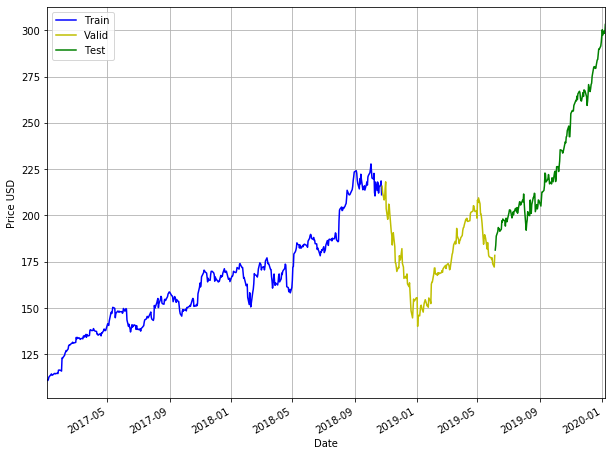

In [139]:
# Plot the data accordingly
rcParams['figure.figsize'] = 10, 8
ax = train.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='g-', grid=True, ax=ax)
ax.legend(['Train', 'Valid', 'Test'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")

# Prediction by Linear Regression

Introduction

The most basic machine learning algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.

The equation for linear regression can be written as:

Here, x1, x2,….xn represent the independent variables while the coefficients θ1, θ2, …. θn represent the weights. You can refer to the following article to study linear regression in more detail:


In [140]:
def preds_lin_reg(apple, target_col, N, pred_min, offset):
    
    #get prediction at timestep t using values from t-1, t-2, ..., t-N.
      # target_col : name of the column you want to predict e.g. 'adj_close'
       # N: get prediction at timestep t using values from t-1, t-2, ..., t-N
        #pred_min : all predictions should be >= pred_min
       # offset: it can be size of training set
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(apple['Adj_Close'])):
        X_train = np.array(range(len(apple['Adj_Close'][i-N:i])))
        y_train = np.array(apple['Adj_Close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)     
        y_train = y_train.reshape(-1, 1)
    # Train the model
        regr.fit(X_train, y_train)            
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [141]:
RMSE = []
R2 = []
MAPE = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = preds_lin_reg(train_cv, 'Adj_Close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['Adj_Close'])))
    R2.append(r2_score(cv['Adj_Close'], est_list))
    MAPE.append(get_mape(cv['Adj_Close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(MAPE))
cv.head()   

RMSE = [3.905844315921211, 5.596721327964514, 5.019769206295928, 4.978407638862982, 4.975430954803471, 4.927458913058318, 4.885796112664123, 4.774656725135466, 4.720793969367129, 4.726949101484141, 4.800000942074946, 4.85372303056591, 4.855911214335038, 4.867761241314721, 4.905053135567641, 5.017137184788405, 5.17168529324248, 5.296857848490742, 5.404598900164277, 5.50377288938014, 5.614150084488982, 5.724206007828147, 5.839341458931085, 5.950108670658729, 6.090340242855644, 6.248246388453958, 6.402119491635694, 6.5721530415423555, 6.7210360381116745, 6.869625398367043]
R2 = [0.9546597568674318, 0.9069060723883529, 0.9251104040398958, 0.9263394603756515, 0.9264275201003361, 0.9278394207547033, 0.9290545305749923, 0.932245476695471, 0.9337655276266658, 0.933592697502918, 0.9315242760281854, 0.9299829243052571, 0.9299197790605873, 0.9295773239532514, 0.9284941752568734, 0.9251889173513368, 0.9205089623540113, 0.9166144834786821, 0.9131877675891694, 0.9099725401333904, 0.906325361777494, 

,Date,Open,High,Low,Close,Adj_Close,Volume,Month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
457,2018-10-25,217.710007,221.380005,216.750000,219.800003,215.793457,29855800,10,211.169296,203.668563,...,213.231951,213.712723,214.248801,214.962671,215.374323,215.851262,216.264190,216.639170,216.553083,216.317439
458,2018-10-26,215.899994,220.190002,212.669998,216.300003,212.357239,47258400,10,215.793457,220.417618,...,212.537606,213.234206,213.673825,214.172489,214.847507,215.238214,215.695100,216.093587,216.457955,216.378626
459,2018-10-29,219.190002,219.690002,206.089996,212.240005,208.371262,45935500,10,212.357239,208.921021,...,211.684539,211.980851,212.648590,213.076247,213.563741,214.223968,214.614393,215.070206,215.471394,215.840795
460,2018-10-30,211.149994,215.179993,209.270004,213.300003,209.411926,36660000,10,208.371262,204.385285,...,210.278503,210.517376,210.826997,211.493070,211.932136,212.429835,213.095195,213.502643,213.973492,214.392107
461,2018-10-31,216.880005,220.449997,216.619995,218.860001,214.870590,38358900,10,209.411926,210.452590,...,209.423472,209.485749,209.721087,210.025818,210.674681,211.109667,211.603293,212.260858,212.672401,213.146363


(2, 30)

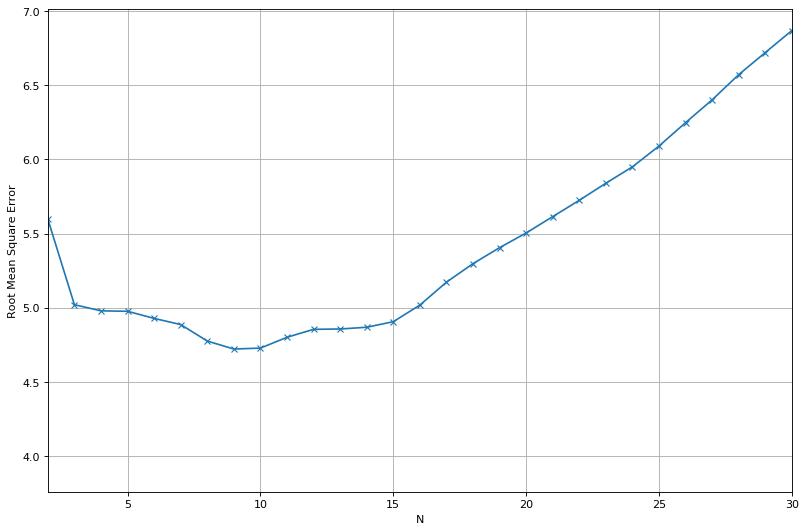

In [142]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('Root Mean Square Error')
plt.xlim([2, 30])

Text(0, 0.5, 'R Squared')

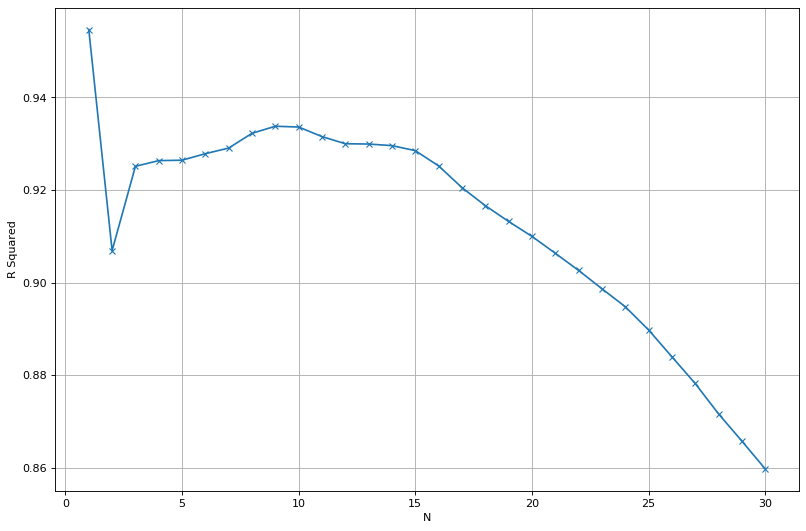

In [143]:
# Plot R2 versus N (R2 larger better)
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, '-x')
plt.grid()
plt.xlabel('N')
plt.ylabel('R Squared')

Text(0, 0.5, 'Mean Absolute Percent Error')

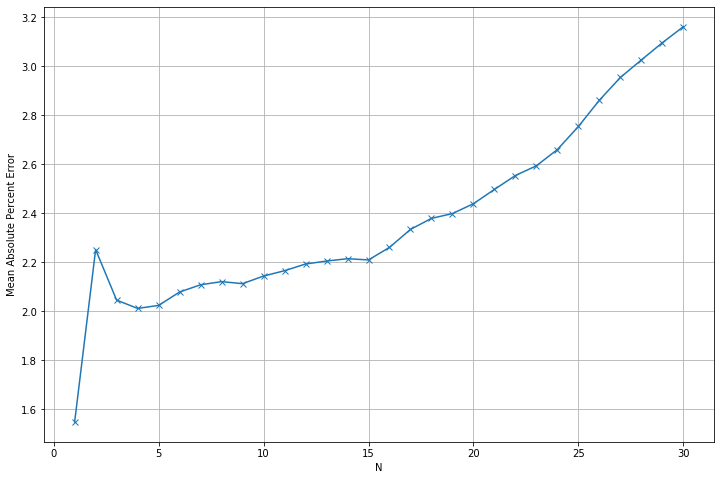

In [144]:
# Plot MAPE versus N. (MAPE smaller better) 
plt.figure(figsize=(12, 8))
plt.plot(range(1, Nmax+1), MAPE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('Mean Absolute Percent Error')

In [145]:
# Set optimum N
N_opt = 5

# Predictions for a specific day by plot

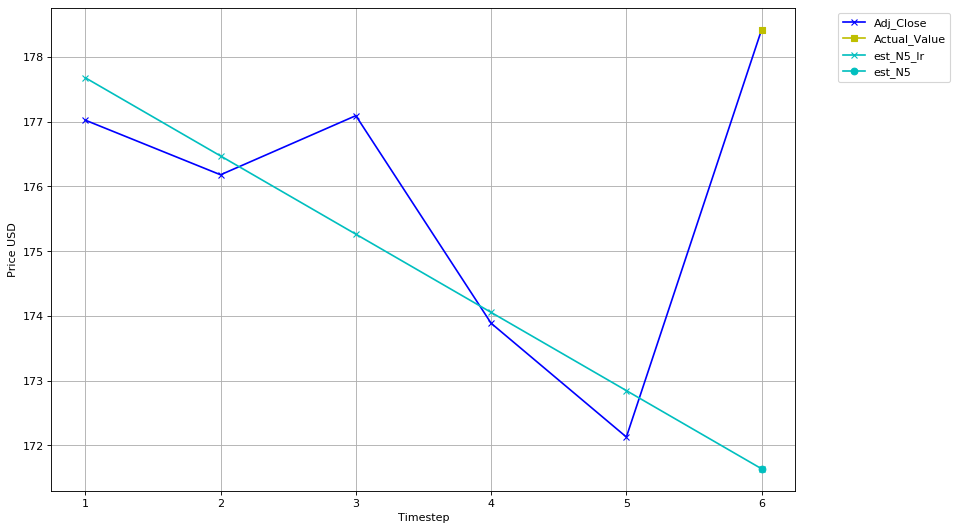

In [146]:
# Specify the day you are interested in
day = pd.Timestamp(date(2019, 6, 30))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 5

apple_temp = cv[cv['Date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), apple_temp[-Nmax2-1:]['Adj_Close'], 'bx-')
plt.plot(Nmax2+1, apple_temp[-1:]['Adj_Close'], 'ys-')
legend_list = ['Adj_Close', 'Actual_Value']
# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(apple_temp['Adj_Close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(apple_temp['Adj_Close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(apple_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             apple_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('Timestep')
plt.ylabel('Price USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))



# Plot predictions on dev set

Text(0, 0.5, 'Price USD')

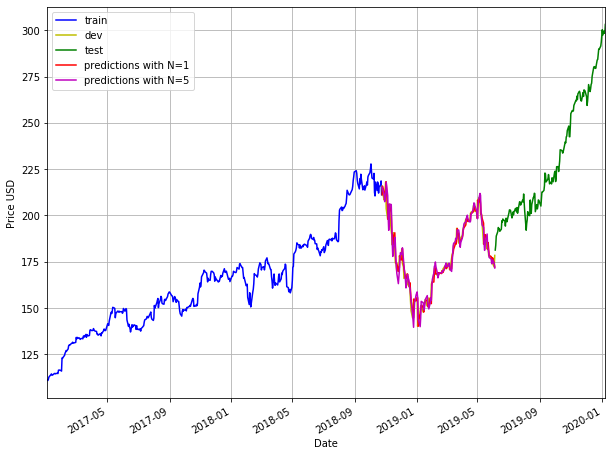

In [147]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8
ax = train.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")

Text(0.5, 1.0, 'Adj close to dev set')

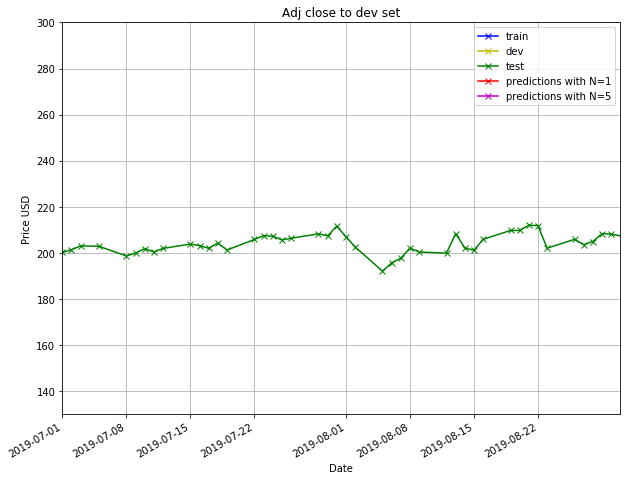

In [148]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8
ax = train.plot(x='Date', y='Adj_Close', style='bx-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
ax.set_xlim([date(2019, 7, 1), date(2019, 8, 31)])
ax.set_ylim(130, 300)
ax.set_title('Adj close to dev set')


# Final Model withTest set

In [152]:
est_list = preds_lin_reg(apple, 'Adj_Close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['Adj_Close'])))
print("R2 = %0.3f" % r2_score(test['Adj_Close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['Adj_Close'], est_list))
test.head()

RMSE = 3.953
R2 = 0.985
MAPE = 1.370%


,Date,Open,High,Low,Close,Adj_Close,Volume,Month,est_N5
608,2019-06-05,184.279999,184.990005,181.139999,182.539993,181.304733,29773400,6,175.398991
609,2019-06-06,183.080002,185.470001,182.149994,185.220001,183.966614,22526300,6,180.455522
610,2019-06-07,186.509995,191.919998,185.770004,190.149994,188.863251,30684400,6,186.743686
611,2019-06-10,191.809998,195.369995,191.619995,192.580002,191.276810,26220900,6,192.641507
612,2019-06-11,194.860001,196.000000,193.600006,194.809998,193.491714,26932900,6,194.746172


Text(0, 0.5, 'Price USD')

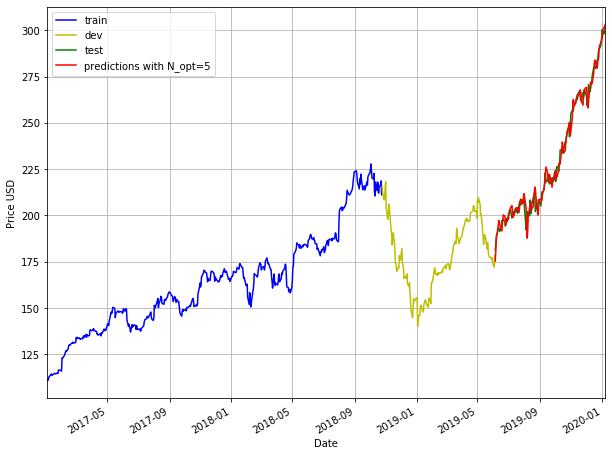

In [153]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='g-', grid=True, ax=ax)
ax = test.plot(x='Date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")

Text(0.5, 1.0, 'Zoom in to test set')

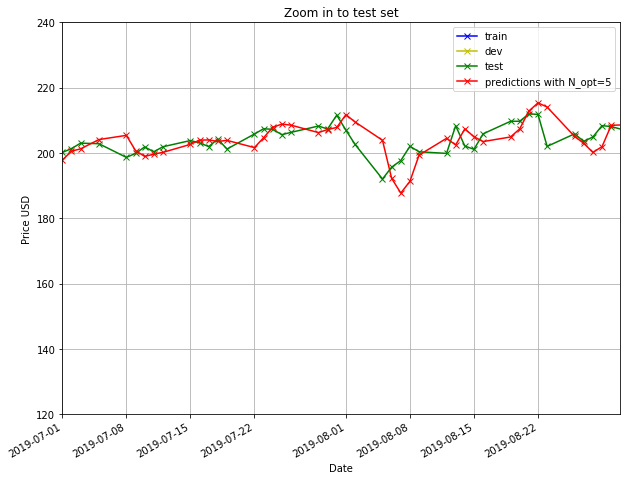

In [155]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # 

ax = train.plot(x='Date', y='Adj_Close', style='bx-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
ax.set_xlim([date(2019, 7, 1), date(2019, 8, 31)])
ax.set_ylim([120, 240])
ax.set_title('Zoom in to test set')

(150, 310)

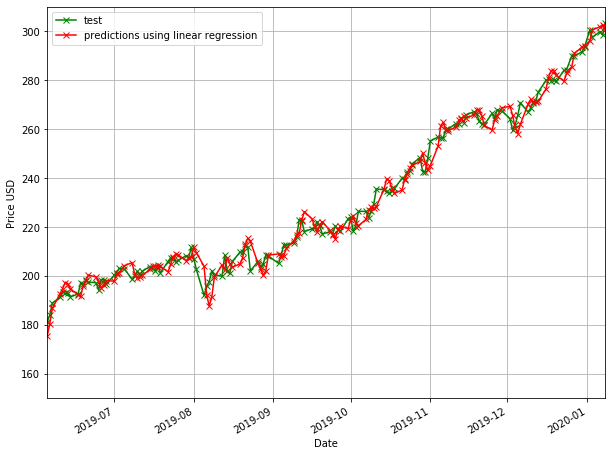

In [157]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 

ax = test.plot(x='Date', y='Adj_Close', style='gx-', grid=True)
ax = test.plot(x='Date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
ax.set_xlim([date(2019, 6, 5), date(2020, 1, 8)])
ax.set_ylim([150, 310])